Michaelel Scheinfeild

# Automated Head Circumference

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from PIL import Image

In [ ]:
use_upload=False
if use_upload:
  from google.colab import files
  uploaded = files.upload()

Saving image_hc_30_example.jpg to image_hc_30_example.jpg


## view examples

Text(0.5, 1.0, 'example1')

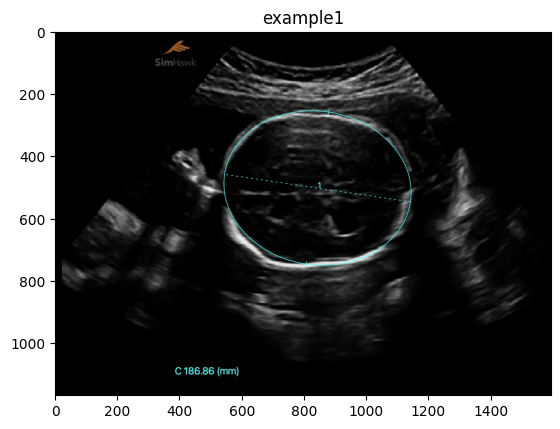

In [ ]:
im1  = cv2.imread('image_hc_104_example.jpg')
plt.imshow(im1)
plt.title('example1')

### check dpi

In [ ]:
image = Image.open('image_hc_104_example.jpg')
print(image.__class__)

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [ ]:
dpi_x, dpi_y = image.info['dpi']
print(dpi_x, dpi_y )

144.0 144.0


In [ ]:
width, height = image.size
print(width,height)

1594 1168


In [ ]:
image.info.keys()

dict_keys(['jfif', 'jfif_version', 'jfif_unit', 'jfif_density', 'exif', 'dpi', 'photoshop', 'icc_profile'])

In [ ]:
image.info['jfif_density']

(144, 144)

In [ ]:
def get_dpi(imgName):
    image = Image.open(imgName)
    dpi_x, dpi_y = image.info['dpi']

    return dpi_x, dpi_y

In [ ]:
def pixelToMM(pixels, DPI):

  millimeter = (pixels / DPI) * 25.4
  return millimeter

### check data

Text(0.5, 1.0, 'example2')

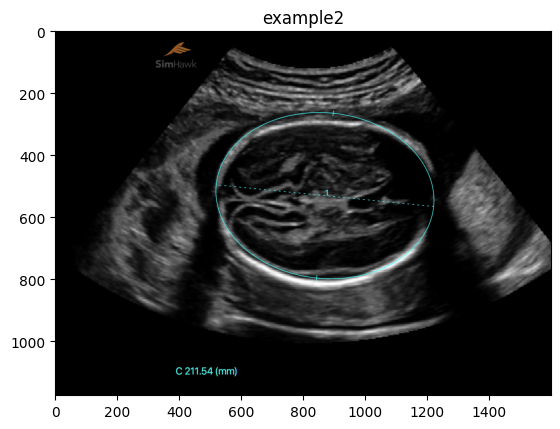

In [ ]:
im2  = cv2.imread('image_hc_30_example.jpg')
plt.imshow(im2)
plt.title('example2')

# Perimeter ellipse

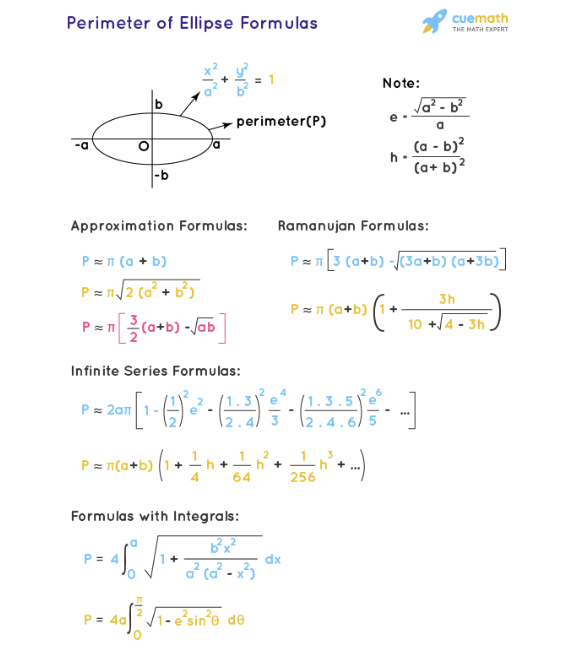

In [ ]:
'''
Ramanujan Formulas of Perimeter of Ellipse

Perimeter ≈ π * (3 * (a + b) - sqrt((3a + b) * (a + 3b)))

In this formula:

    "a" is the length of the semi-major axis.
    "b" is the length of the semi-minor axis.
'''
def calculate_perimeter(a,b):
    perimeter = math.pi * ( 3*(a+b) - math.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

In [ ]:
# check example 1
a=300
b=244
perimeter = calculate_perimeter(a,b)
print('perimeter pixels example1',perimeter)

perimeter pixels example1 1713.5569955907533


In [ ]:
#dpi same
mm_ex1 = pixelToMM(perimeter, dpi_x)
print('mm example1',mm_ex1)

mm example1 302.2524145000356


seems some mismatch text in images of perimeter mm so tested in matlab also found possible scale 0.,5 but still 20% change
%186   vs 151 M
mmperimeter = scale X tomm X perimeter/dpi

%211 vs 171
mmperimeterSec = scale*tomm*perimetersec/dpi
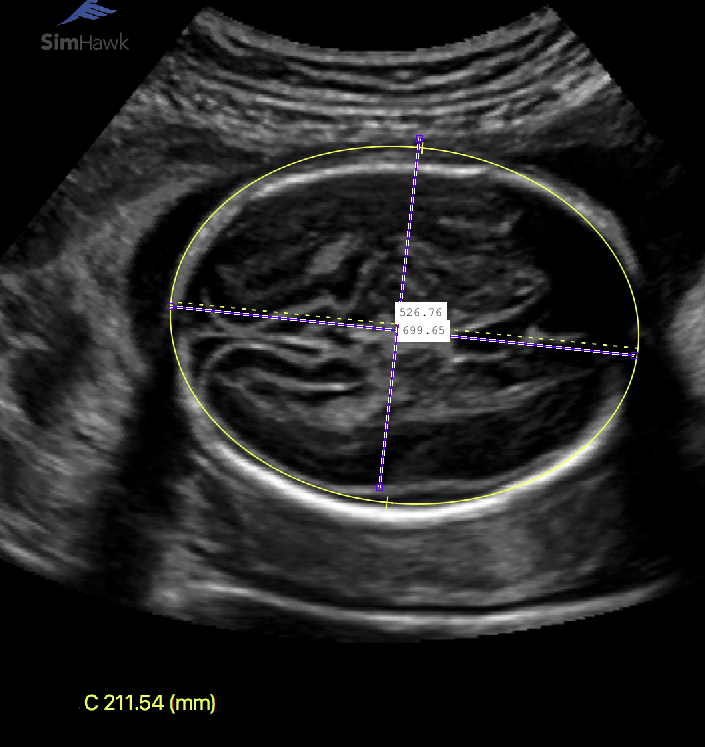



# Process Image1

Text(0.5, 1.0, '104')

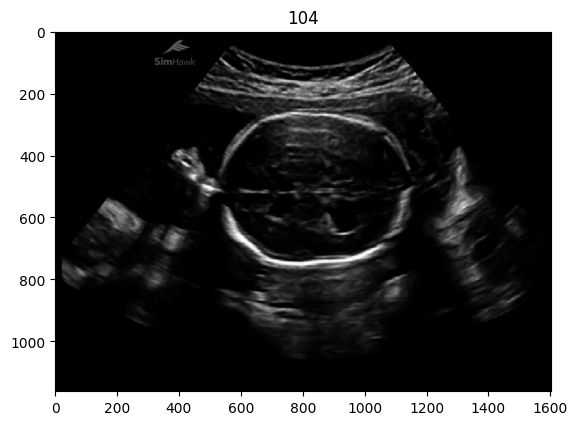

In [ ]:
# Load the ultrasound head image
image = cv2.imread('image_hc_104.jpg')

# Preprocess the image (e.g., convert to grayscale and apply thresholding)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(gray,cmap='gray')
plt.title('104')


### Preprocess stage2

Text(0.5, 1.0, '104 thresh')

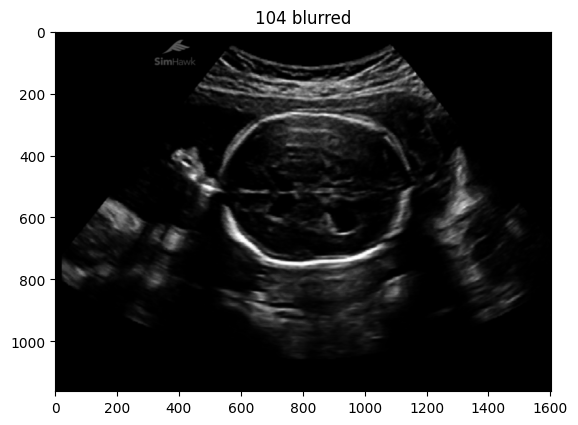

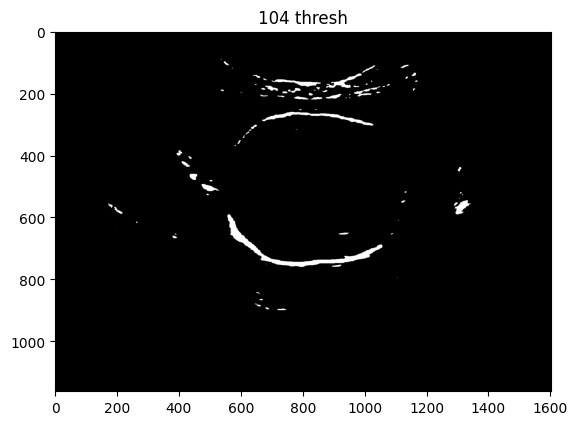

In [ ]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY)

plt.figure()
plt.imshow(blurred,cmap='gray')
plt.title('104 blurred')

plt.figure()
plt.imshow(thresh,cmap='gray')
plt.title('104 thresh')

### clean small objecta

In [ ]:
def cleanArea(binary_image,area_threshold = 100):
    # Adjust this value according to your needs

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask to store the selected contours
    mask = np.zeros_like(binary_image)

    # Iterate through the contours
    for contour in contours:
        area = cv2.contourArea(contour)
        if area >= area_threshold:
            # Draw the contour on the mask
            cv2.drawContours(mask, [contour], 0, 255, -1)

    # Bitwise-AND the mask with the original binary image
    cleaned_image = cv2.bitwise_and(binary_image, binary_image, mask=mask)

    return cleaned_image

Text(0.5, 1.0, 'cleaned image thresh')

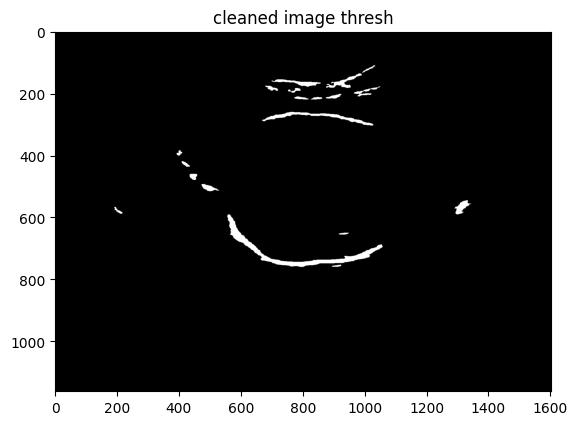

In [ ]:
threhclean = cleanArea(thresh)
plt.figure()
plt.imshow(threhclean,cmap='gray')
plt.title('cleaned image thresh')

Text(0.5, 1.0, 'closed image')

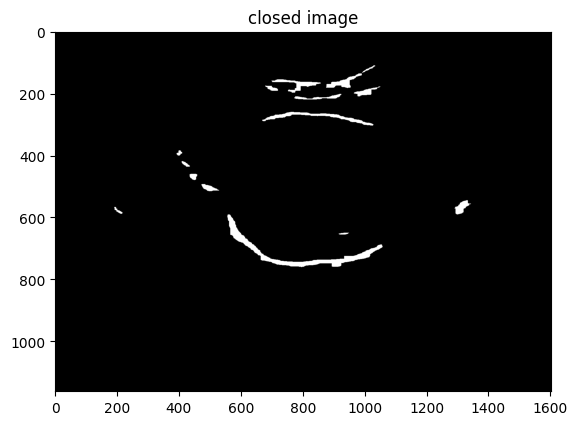

In [ ]:
# Define the kernel for the morphological operation (structuring element)
kernel = np.ones((15, 15), np.uint8)  # You can adjust the kernel size as needed

# Apply morphological closing to connect the moon-shaped blobs
closed_image = cv2.morphologyEx(threhclean, cv2.MORPH_CLOSE, kernel)

plt.figure()
plt.imshow(closed_image,cmap='gray')
plt.title('closed image')

Text(0.5, 1.0, 'cleaned image thresh after close')

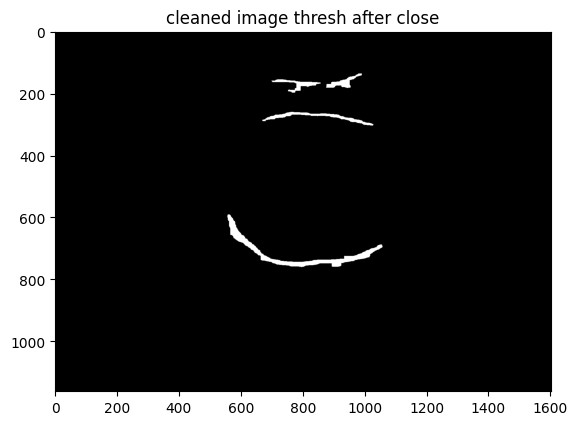

In [ ]:
threhclean = cleanArea(closed_image,1500)
plt.figure()
plt.imshow(threhclean,cmap='gray')
plt.title('cleaned image thresh after close')

In [ ]:
# 2. Detect ellipses using contour finding
contours, _ = cv2.findContours(threhclean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

This code reads an image, preprocesses it, detects ellipses, and counts the number of detected ellipses.

In [ ]:
detected_ellipses = []
for contour in contours:
    if len(contour) >= 20:  # Ensure there are enough points to fit an ellipse
        ellipse = cv2.fitEllipse(contour)
        detected_ellipses.append(ellipse)

# 3. Analyze the detected ellipses
num_ellipses = len(detected_ellipses)
print(f"Number of Detected Ellipses: {num_ellipses}")

Number of Detected Ellipses: 4


Text(0.5, 1.0, 'detectedellipse threshold')

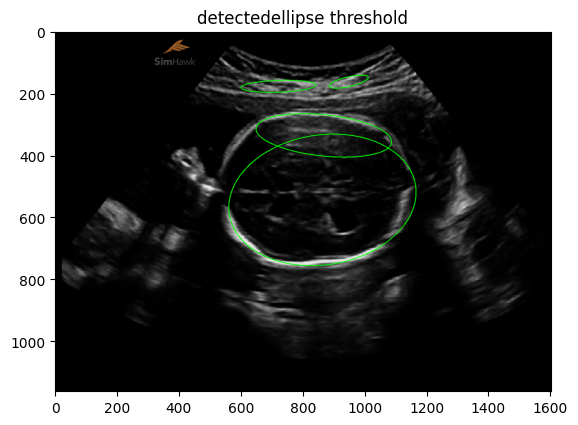

In [ ]:
imageDraw = cv2.imread('image_hc_104.jpg')
# draw the detected ellipses:
for ellipse in detected_ellipses:
    if ellipse[1][0] >= 0 and ellipse[1][1] >= 0:  # Check for valid ellipse dimensions
            cv2.ellipse(imageDraw, ellipse, (0, 255, 0), 2)

plt.imshow(imageDraw)
plt.title('detectedellipse threshold')

Text(0.5, 1.0, 'detectedellipse binary threshold')

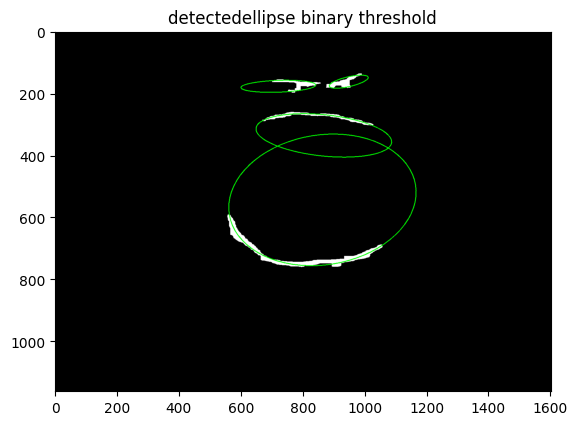

In [ ]:
threhcleanC = cv2.cvtColor(threhclean,cv2.COLOR_GRAY2RGB)#np.copy(threhclean)
# draw the detected ellipses:
for ellipse in detected_ellipses:
    if ellipse[1][0] >= 0 and ellipse[1][1] >= 0:  # Check for valid ellipse dimensions
            cv2.ellipse(threhcleanC, ellipse, (0, 255, 0), 2)

plt.imshow(threhcleanC,cmap='gray' )
plt.title('detectedellipse binary threshold')

### by edges

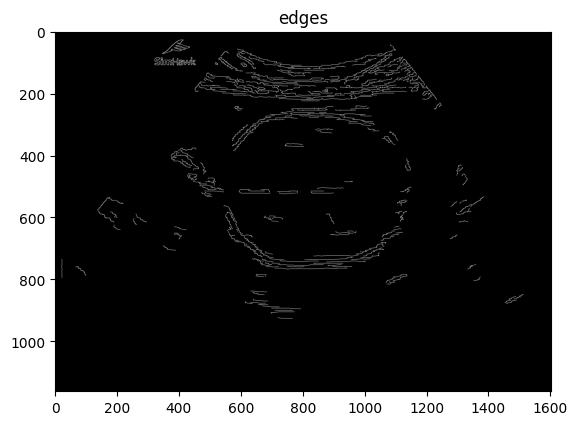

In [ ]:
# Detect edges using the Canny edge detector
edges = cv2.Canny(blurred, 50, 150)

plt.figure()
plt.imshow(edges,cmap='gray')
plt.title('edges')

# Find contours in the edge image
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


In [ ]:
detected_ellipses = []
for contour in contours:
    if len(contour) >= 10:  # Ensure there are enough points to fit an ellipse
        ellipse = cv2.fitEllipse(contour)
        detected_ellipses.append(ellipse)

# 3. Analyze the detected ellipses
num_ellipses = len(detected_ellipses)
print(f"Number of Detected Ellipses: {num_ellipses}")

Number of Detected Ellipses: 362


Text(0.5, 1.0, 'detectedellipse canny')

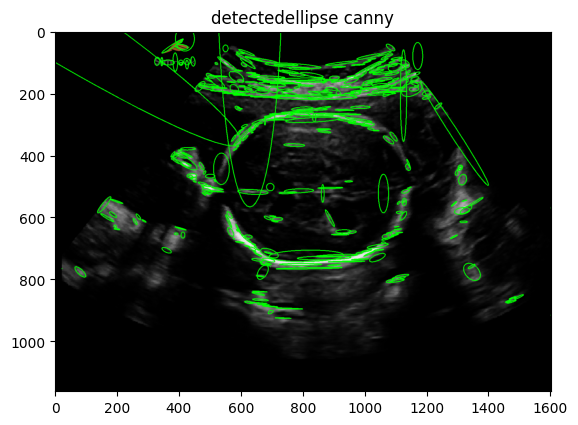

In [ ]:
imageDraw = cv2.imread('image_hc_104.jpg')

# draw the detected ellipses:
for ellipse in detected_ellipses:
    if ellipse[1][0] >= 0 and ellipse[1][1] >= 0:  # Check for valid ellipse dimensions
            cv2.ellipse(imageDraw, ellipse, (0, 255, 0), 2)

plt.imshow(imageDraw)
plt.title('detectedellipse canny')

### Function view on all images

In [ ]:
nameFiles = ['image_hc_104.jpg','image_hc_17.jpg','image_hc_30.jpg','image_hc_7.jpg']

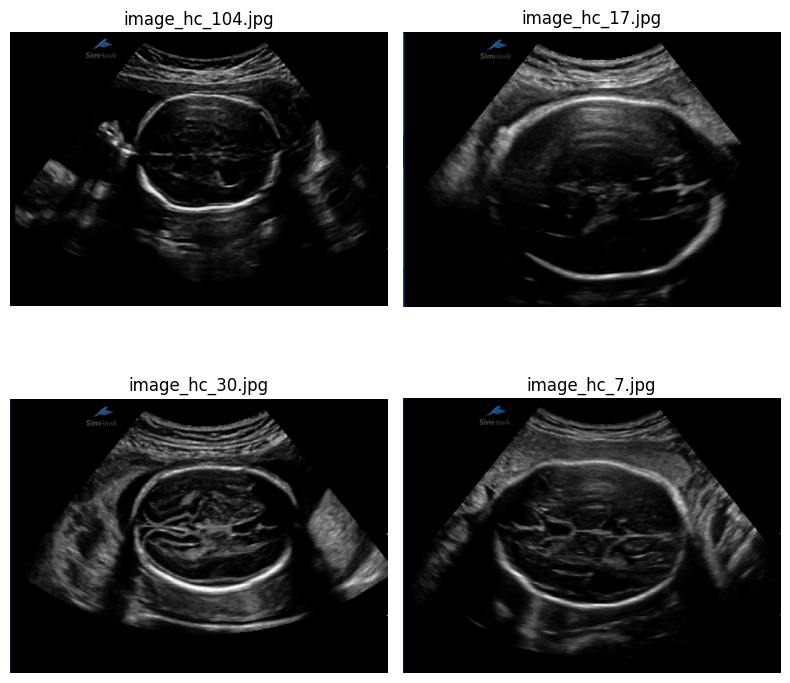

In [ ]:
# Create a 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Loop through the file names and plot the images
for i, file_name in enumerate(nameFiles):
    # Read the image using OpenCV
    image = cv2.imread(file_name)

    # Convert BGR image to RGB (if needed)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Plot the image on the grid
        row, col = divmod(i, 2)
        axes[row, col].imshow(image)
        axes[row, col].set_title(file_name)

# Hide axis labels
for ax in axes.flat:
    ax.axis('off')

# Adjust layout
plt.tight_layout()

In [ ]:
def seperateBlobs(image,plotFlag=False):

  # Find contours in the binary image
  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Create a blank mask to draw the separated blobs
  separated_blobs = np.zeros_like(image)

  # Draw each blob separately on the mask
  for i, contour in enumerate(contours):
      # Create a mask for the current blob
      blob_mask = np.zeros_like(image)
      cv2.drawContours(blob_mask, [contour], 0, 255, thickness=cv2.FILLED)

      # Use a different color for each separated blob
      color = (i % 256, (i * 3) % 256, (i * 5) % 256)  # Generates a unique color for each blob
      separated_blobs = cv2.add(separated_blobs, cv2.bitwise_and(image, image, mask=blob_mask))

      #if(plotFlag):
      #  plt.imshow(blob_mask, cmap='gray')  # Display each blob separately
      #  plt.title(f'Blob {i}')


  if(plotFlag):
    # Display the separated blobs
    plt.figure(figsize=(6, 8))
    plt.imshow(separated_blobs, cmap='gray')
    plt.title('Separated Blobs')


  return separated_blobs


#### Normalization

In [ ]:
def percentile_normalize(image, lower_percentile=2, upper_percentile=98):
    """
    Perform percentile normalization on an image.

    Args:
    image (numpy.ndarray): The input image as a NumPy array.
    lower_percentile (float): The lower percentile for normalization (default: 2).
    upper_percentile (float): The upper percentile for normalization (default: 98).

    Returns:
    numpy.ndarray: The percentile-normalized image in the uint8 (0-255) range.
    """

    # Calculate the lower and upper bounds based on the specified percentiles
    lower_bound = np.percentile(image, lower_percentile)
    upper_bound = np.percentile(image, upper_percentile)

    # Apply percentile normalization
    normalized_image = np.clip(image, lower_bound, upper_bound)
    normalized_image = (normalized_image - lower_bound) / (upper_bound - lower_bound)

    # Scale the normalized image to the uint8 range (0-255)
    normalized_image = (normalized_image * 255).astype(np.uint8)

    return normalized_image

#### function ellipse

In [ ]:
def getEllipse(imgGray,blurSize=5,opensize=5,cleanSize=500,minCntr=20, plotFlag = False, name='0'):

  szP=(4,6)
  fontsize=8

  if(plotFlag):
     plt.figure(figsize=szP)
     plt.imshow(imgGray,cmap='gray')
     plt.title(['gray '+ name],fontsize=fontsize)

  grayNorm = percentile_normalize(imgGray)

  blurred = cv2.GaussianBlur(grayNorm, (blurSize, blurSize), 0)
  #_, thresh = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY)
  # Apply Otsu's thresholding
  _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  if(plotFlag):
    plt.figure(figsize=szP)
    plt.imshow(blurred,cmap='gray')
    plt.title(['blurred ' + name],fontsize=fontsize )

    plt.figure(figsize=szP)
    plt.imshow(thresh,cmap='gray')
    plt.title(['thresh' + name],fontsize=fontsize)

  #separated_blobs = seperateBlobs(thresh,plotFlag)

  # Define a kernel (structuring element)
  kernel = np.ones((opensize, opensize), np.uint8)  # You can adjust the kernel size as needed

  # Perform the opening operation
  opened_image = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

  if(plotFlag):
    plt.figure(figsize=szP)
    plt.imshow(opened_image,cmap='gray')
    plt.title(['opened_image ' + name] ,fontsize=fontsize)


  threhclean = cleanArea( opened_image,cleanSize)
  if(plotFlag):
    plt.figure(figsize=szP)
    plt.imshow(threhclean,cmap='gray')
    plt.title(['cleaned image thresh after close '+ name],fontsize=fontsize)


  #  Detect ellipses using contour finding
  contours, _ = cv2.findContours(threhclean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


  detected_ellipses = []
  for contour in contours:
      if len(contour) >= minCntr:  # Ensure there are enough points to fit an ellipse
          ellipse = cv2.fitEllipse(contour)
          detected_ellipses.append(ellipse)

  #  Analyze the detected ellipses
  num_ellipses = len(detected_ellipses)
  print(f"Number of Detected Ellipses: {num_ellipses}")


  imageDraw = cv2.cvtColor(imgGray,cv2.COLOR_GRAY2RGB)
  # draw the detected ellipses:
  for ellipse in detected_ellipses:
    if ellipse[1][0] >= 0 and ellipse[1][1] >= 0:  # Check for valid ellipse dimensions
            cv2.ellipse(imageDraw, ellipse, (255, 0, 0), 8)

  if(plotFlag):

    plt.figure(figsize=szP)
    plt.imshow(imageDraw,cmap='gray')
    plt.title(['detectedellipse threshold' + name],fontsize=fontsize)

    threhcleanC = cv2.cvtColor(threhclean,cv2.COLOR_GRAY2RGB)#np.copy(threhclean)
    # draw the detected ellipses
    for ellipse in detected_ellipses:
       if ellipse[1][0] >= 0 and ellipse[1][1] >= 0:  # Check for valid ellipse dimensions
            cv2.ellipse(threhcleanC, ellipse, ( 255,0, 0),8)

            # Assuming you have an ellipse stored in 'ellipse' (from cv2.fitEllipse)
            a, b = ellipse[1][0] / 2, ellipse[1][1] / 2

            # Calculate the perimeter
            perimeter = 2 * np.pi * np.sqrt((a ** 2 + b ** 2) / 2)
            print("Ellipse Perimeter:", perimeter)

    plt.figure(figsize=szP)
    plt.imshow(threhcleanC,cmap='gray' )
    plt.title(['detectedellipse binary threshold'+name],fontsize=fontsize)

In [ ]:
nameFiles = ['image_hc_104.jpg','image_hc_17.jpg','image_hc_30.jpg','image_hc_7.jpg']

Number of Detected Ellipses: 14
Number of Detected Ellipses: 3
Number of Detected Ellipses: 12


<ipython-input-145-65627287fc53>:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=szP)


Number of Detected Ellipses: 15


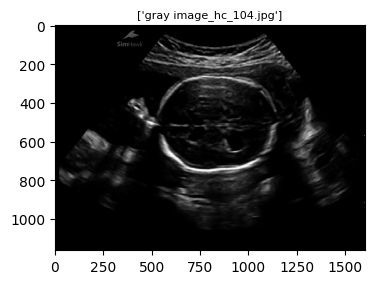

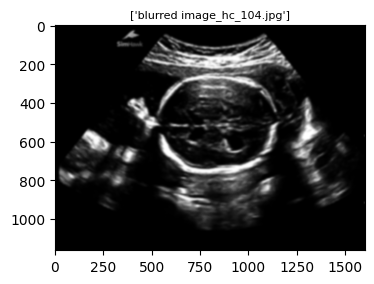

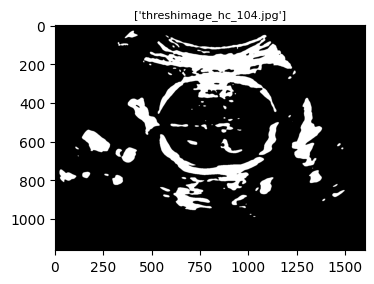

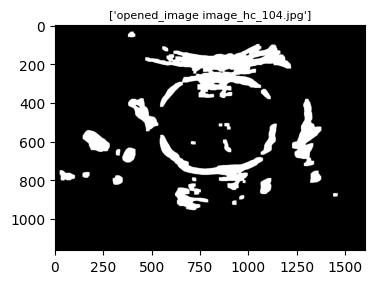

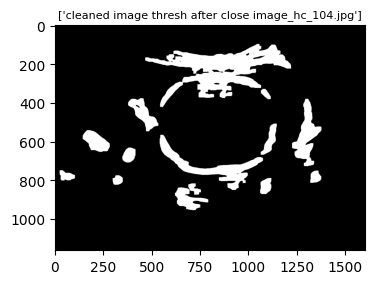

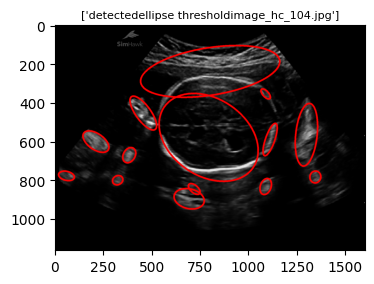

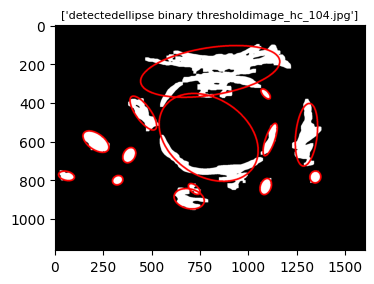

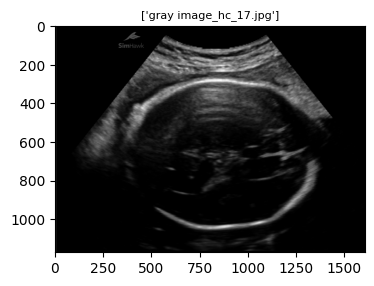

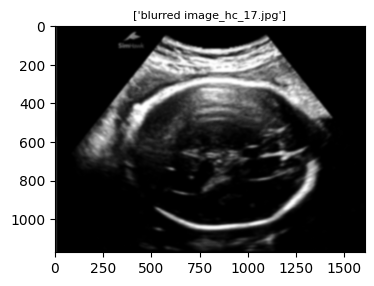

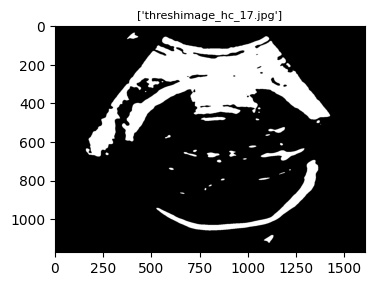

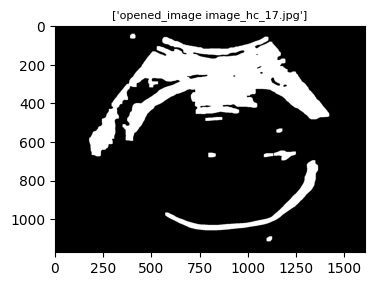

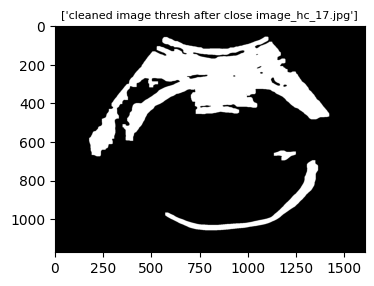

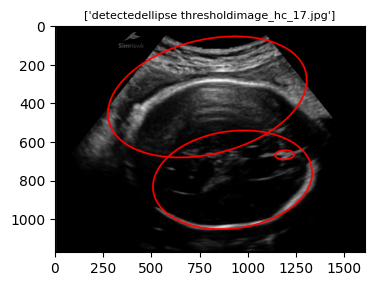

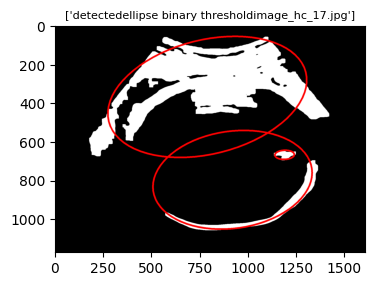

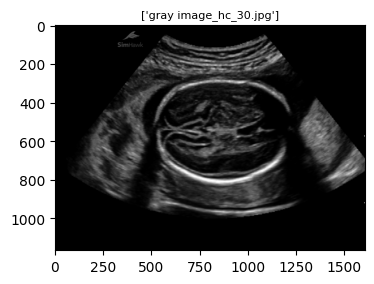

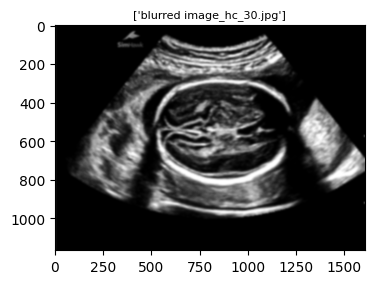

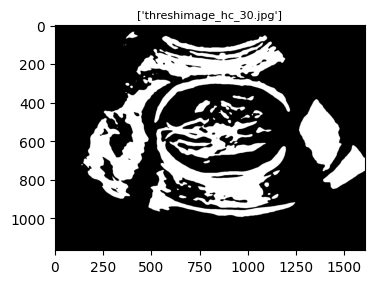

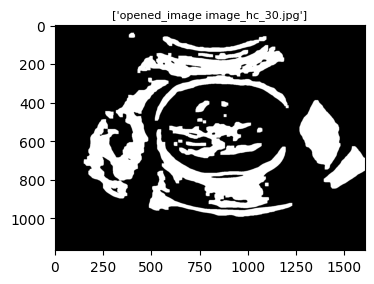

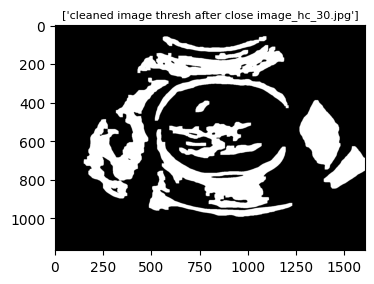

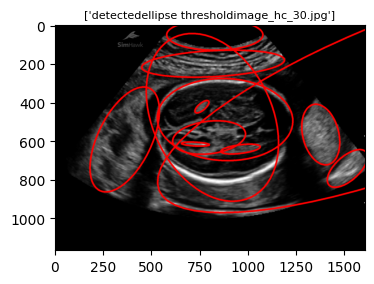

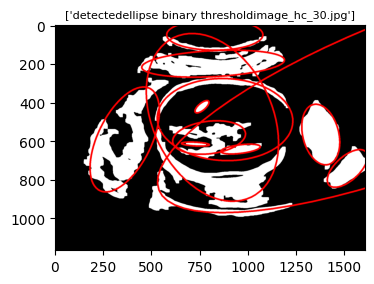

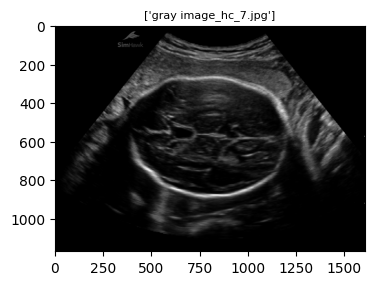

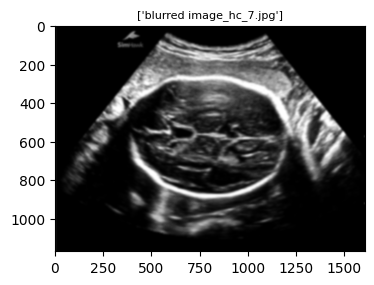

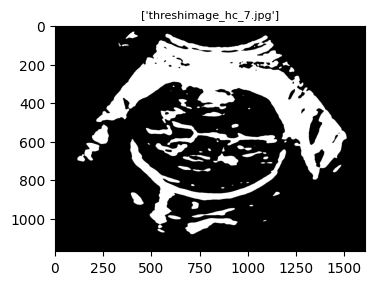

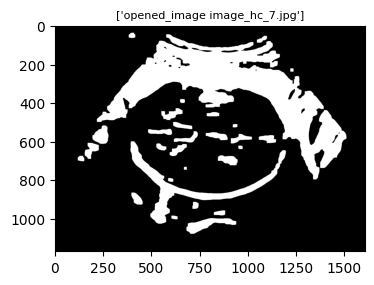

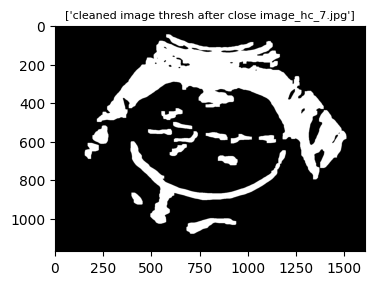

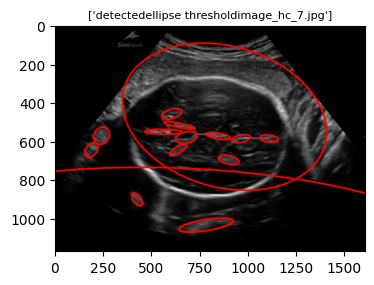

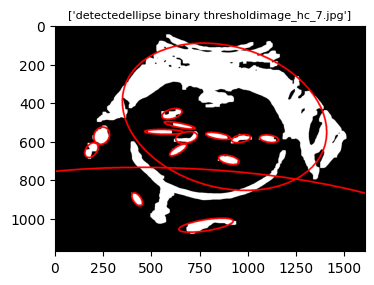

In [ ]:
blursize  =25
opensize  =15
cleanSize=1500
minCntr=20
plotFlag=True
for i, file_name in enumerate(nameFiles):
    gray =   cv2.imread(file_name,cv2.IMREAD_GRAYSCALE)
    getEllipse(gray, blursize,opensize,cleanSize,minCntr,plotFlag, name=file_name)

# References



*   https://stackoverflow.com/questions/42310956/how-to-calculate-the-perimeter-of-an-ellipse
*   https://www.cuemath.com/measurement/perimeter-of-ellipse/
* https://docs.opencv.org/4.x/da/d53/tutorial_py_houghcircles.html
*
*

